# benchmark analysis

This is a text cell. Start editing!

In [1]:
val framework = "zhttp20"
val df = spark.read
   .option("header",true)
   .option("inferSchema" , true)
   .csv("notebooks/results/jmeter/msdemo-test1-zhttp-1629004962.csv")
   .sort("timestamp")
df.show()

+-------------+-------+---------------+------------+---------------+----------+--------+-------+--------------+-----+---------+----------+----------+--------------------+-------+--------+-------+
|    timeStamp|elapsed|          label|responseCode|responseMessage|threadName|dataType|success|failureMessage|bytes|sentBytes|grpThreads|allThreads|                 URL|Latency|IdleTime|Connect|
+-------------+-------+---------------+------------+---------------+----------+--------+-------+--------------+-----+---------+----------+----------+--------------------+-------+--------+-------+
|1629004974783|    422|GET /media/demo|         200|             OK| Users 1-2|    text|   true|          null|21184|      133|        59|        59|http://localhost:...|    422|       0|     39|
|1629004974783|    428|GET /media/demo|         200|             OK| Users 1-3|    text|   true|          null|21184|      133|        59|        59|http://localhost:...|    428|       0|     40|
|1629004974783|    4

In [2]:
val latency = df.select("Latency")
val bins = (0 to 200 by 1).map(_.toDouble).toArray
val hist = latency.rdd
  .map(value => value.getInt(0))
  .histogram(bins, true)

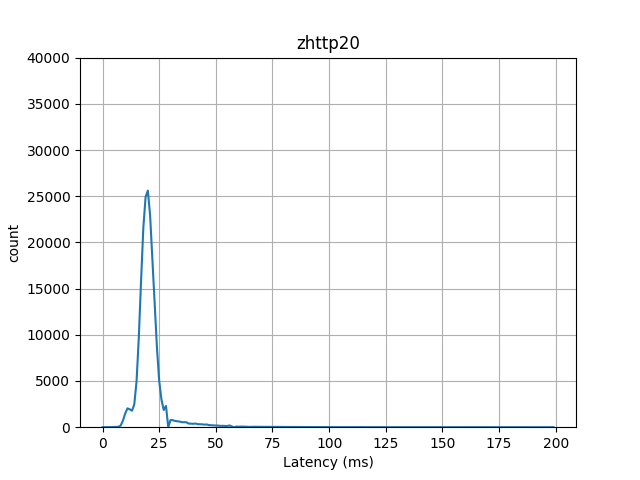

In [3]:
import matplotlib.pyplot as plt
# plt.hist(hist, bins, density=True, facecolor='g', alpha=0.7)
plt.plot(bins[:-1], hist)
plt.grid(True)
plt.title(framework)
plt.ylim(0, 40000)
plt.ylabel("count")
plt.xlabel("Latency (ms)")
plt.savefig("notebooks/results/{}_latency.png".format(framework))
plt.show()


In [4]:
import org.apache.spark.sql.expressions.Window
val window = Window.orderBy("timestamp")
  .rangeBetween(-1000L, 0L)
val minTime = df.select($"timestamp")
  .agg(min("timestamp"))
  .head
  .get(0)
val timestamps = df.select($"timestamp".minus(minTime).as("timestamp"))
val throughput = timestamps.select($"timestamp", 
  count("timestamp")
    .over(window)
    .as("throughput"))
val x = throughput.select("timestamp").rdd.map(r => r(0)).collect()
val y = throughput.select("throughput").rdd.map(r => r(0)).collect()

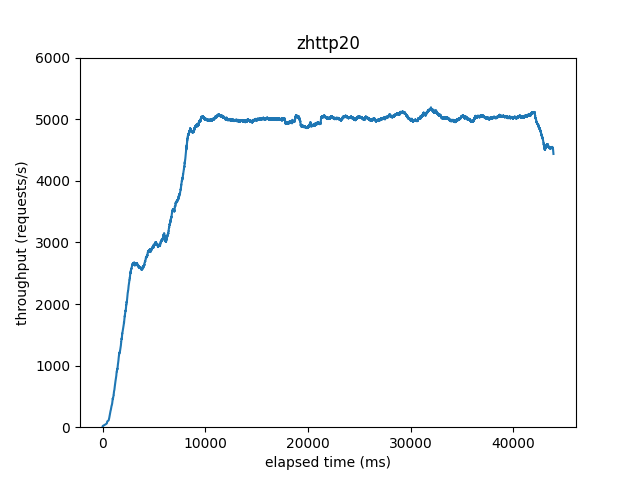

In [5]:
# import matplotlib.pyplot as plt
plt.plot(x, y)
plt.ylim(0, 6000)
plt.title(framework)
plt.xlabel("elapsed time (ms)")
plt.ylabel("throughput (requests/s)")
plt.savefig("notebooks/results/{}_throughput.png".format(framework))
plt.show()
